In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc
history = []

In [2]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business', 'general'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [221]:
selected = [ID for ID, item in tqdm(spark_generator.articles.items()) if 'climate' in f'{item["title"]} {item["description"]}'.lower()]
len(selected)

In [247]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
@tool('seed')
def from_selected(): return random.choice(selected)
ctx.include(from_selected)
# print(ctx)
# ctx['seed'] = 2907356#7216462#2494534#91220#1684065#6805333
if not ctx.is_cached('seed'): history.append(ctx['seed'])
print(ctx['seed'])
print(ctx['spark'])

6008403
Title: CFC ban halted climate catastrophe, scientists say - BBC News
Description: A global treaty banning ozone-depleting chemicals in 1987 may have averted a climate catastrophe today.
Original Language: English


In [248]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: CFC ban halted climate catastrophe, scientists say - BBC News
Description: A global treaty banning ozone-depleting chemicals in 1987 may have averted a climate catastrophe today.
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis" or "model" and avoid starting with "imagine") an

In [249]:
##############################################
motivation_raw = '''
{
  "title": "Ozone_Recovery_and_Climate_Change_Impact",
  "introduction": "This article brings to light how the 1987 global treaty to ban CFCs, chemicals harming the ozone layer, might have helped us avoid severe climate issues today. To explore this further, we could look at historical temperature records, greenhouse gas levels, and ozone layer measurements over the past few decades. By comparing these data before and after the ban, we might see how significantly this action contributed to slowing down climate change."
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [250]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [262]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Climate Stability",
    "description": "The stability of global climate patterns, with 0 indicating instability and 1 indicating stability.",
    "type": "outcome",
    "observed": true,
    "values": ["Unstable", "Stable"],
    "parents": ["CFC Ban Implementation", "Ozone Layer Recovery", "Greenhouse Gas Emissions"]
  },
  {
    "name": "CFC Ban Implementation",
    "description": "Implementation of the ban on CFCs, with 0 being no ban and 1 being a fully enforced ban.",
    "type": "treatment",
    "observed": true,
    "values": ["No Ban", "Enforced Ban"],
    "parents": ["Public Awareness of Climate Issues", "Environmental Policies"]
  },
  {
    "name": "Public Awareness of Climate Issues",
    "description": "Public awareness and concern about climate issues, with 0 indicating low awareness and 1 high awareness.",
    "type": "treatment",
    "observed": true,
    "values": ["Low Awareness", "High Awareness"],
    "parents": ["Environmental Policies"]
  },
  {
    "name": "Industrial Growth",
    "description": "The rate of industrial growth, with 0 being low growth and 1 high growth.",
    "type": "confounder",
    "observed": true,
    "values": ["Low Growth", "High Growth"],
    "parents": ["Environmental Policies"]
  },
  {
    "name": "Environmental Policies",
    "description": "The presence and effectiveness of environmental policies, with 0 indicating weak policies and 1 strong policies.",
    "type": "confounder",
    "observed": true,
    "values": ["Weak Policies", "Strong Policies"],
    "parents": []
  },
  {
    "name": "Ozone Layer Recovery",
    "description": "The state of the ozone layer's recovery, with 0 indicating poor recovery and 1 indicating good recovery.",
    "type": "mediator",
    "observed": true,
    "values": ["Poor Recovery", "Good Recovery"],
    "parents": ["CFC Ban Implementation"]
  },
  {
    "name": "Greenhouse Gas Emissions",
    "description": "The level of greenhouse gas emissions, with 0 being high emissions and 1 being low emissions.",
    "type": "mediator",
    "observed": true,
    "values": ["High Emissions", "Low Emissions"],
    "parents": ["Public Awareness of Climate Issues", "Industrial Growth"]
  },
  {
    "name": "Research Investment in Climate Science",
    "description": "Investment in climate science research, with 0 being low investment and 1 being high investment.",
    "type": "collider",
    "observed": true,
    "values": ["Low Investment", "High Investment"],
    "parents": ["Public Awareness of Climate Issues", "Climate Stability"]
  }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

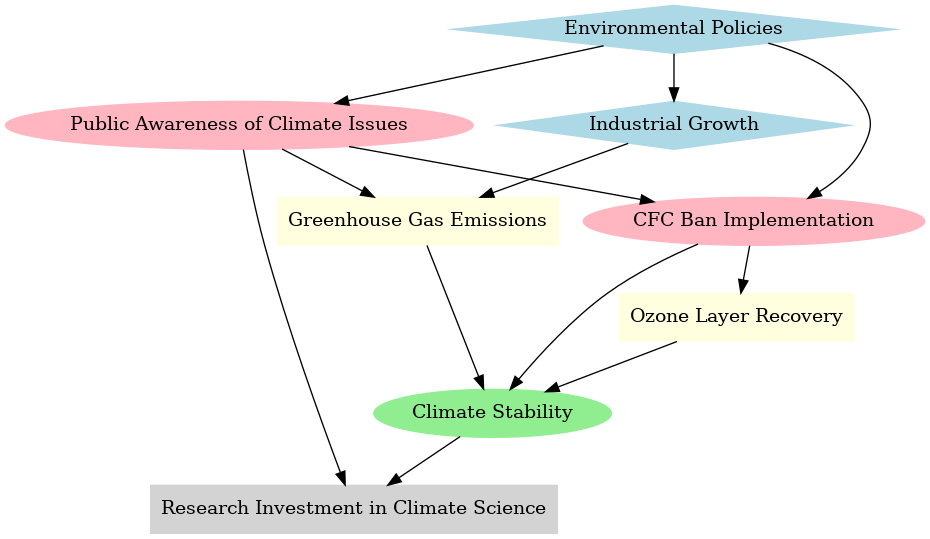

In [263]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [264]:
# if 'prompt_structure' in ctx:
#     del ctx['prompt_structure']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

This article brings to light how the 1987 global treaty to ban CFCs, chemicals harming the ozone layer, might have helped us avoid severe climate issues today. To explore this further, we could look at historical temperature records, greenhouse gas levels, and ozone layer measurements over the past few decades. By comparing these data before and after the ban, we might see how significantly this action contributed to slowing down climate change.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects", 

In [266]:
#################################################

structure_raw = '''
[
    {"sentence": "The effectiveness of environmental policies not only plays a critical role in how strongly the public becomes aware of climate issues but also directly influences the implementation of measures like the CFC ban.", "involved": ["Environmental Policies", "Public Awareness of Climate Issues", "CFC Ban Implementation"]},
    {"sentence": "Interestingly, the level of public concern about climate issues is seen as a key driver for the enforcement of the CFC ban, highlighting how societal awareness can impact policy decisions.", "involved": ["Public Awareness of Climate Issues", "CFC Ban Implementation"]},
    {"sentence": "The enforcement of the CFC ban is assumed to be a major contributing factor to the recovery of the ozone layer, underlining the direct impact of policy decisions on environmental health.", "involved": ["CFC Ban Implementation", "Ozone Layer Recovery"]},
    {"sentence": "Industrial growth is considered a dual influencer, contributing to greenhouse gas emissions while also being shaped by the prevailing environmental policies.", "involved": ["Industrial Growth", "Greenhouse Gas Emissions", "Environmental Policies"]},
    {"sentence": "The combined effects of ozone layer recovery and the levels of greenhouse gas emissions are believed to be pivotal in determining the stability of the global climate.", "involved": ["Ozone Layer Recovery", "Greenhouse Gas Emissions", "Climate Stability"]},
    {"sentence": "Research investment in climate science is uniquely positioned, being influenced by both the general public's awareness of climate issues and the overall stability of the climate itself.", "involved": ["Research Investment in Climate Science", "Public Awareness of Climate Issues", "Climate Stability"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [267]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

This article brings to light how the 1987 global treaty to ban CFCs, chemicals harming the ozone layer, might have helped us avoid severe climate issues today. To explore this further, we could look at historical temperature records, greenhouse gas levels, and ozone layer measurements over the past few decades. By comparing these data before and after the ban, we might see how significantly this action contributed to slowing down climate change.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Environmental Policies" is "Strong Policies" (rather than "Weak Policies")?
2. when "Environmental Policies" is "Weak Policies": what is the probability that "Public Awareness of Climate Issues" is "High Awareness" (rather than "Low Awareness")?
3. when "Environmental Policies" is 

In [268]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.5, 0.7],
  "2": [0.2, 0.4],
  "3": [0.6, 0.8],
  "4": [0.1, 0.2],
  "5": [0.3, 0.5],
  "6": [0.4, 0.6],
  "7": [0.7, 0.9],
  "8": [0.6, 0.8],
  "9": [0.3, 0.5],
  "10": [0.1, 0.2],
  "11": [0.7, 0.9],
  "12": [0.4, 0.6],
  "13": [0.7, 0.9],
  "14": [0.5, 0.7],
  "15": [0.8, 0.9],
  "16": [0.1, 0.3],
  "17": [0.3, 0.5],
  "18": [0.2, 0.4],
  "19": [0.4, 0.6],
  "20": [0.2, 0.4],
  "21": [0.4, 0.6],
  "22": [0.5, 0.7],
  "23": [0.7, 0.9],
  "24": [0.3, 0.5],
  "25": [0.5, 0.7],
  "26": [0.4, 0.6],
  "27": [0.6, 0.8]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [269]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions)#.item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

----------------------------------  -------------  --------------  --------------------------------------------------------------------------------------------------------
Public Awareness of Climate Issues  Low Awareness  High Awareness  Public awareness and concern about climate issues, with 0 indicating low awareness and 1 high awareness.
CFC Ban Implementation              No Ban         Enforced Ban    Implementation of the ban on CFCs, with 0 being no ban and 1 being a fully enforced ban.
Climate Stability                   Unstable       Stable          The stability of global climate patterns, with 0 indicating instability and 1 indicating stability.
----------------------------------  -------------  --------------  --------------------------------------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Environmental Policies' means The presence and effectiveness of environmental policies, with 0 indicating weak policies and 1 strong policies.
'Public Awareness of Climate Issues' means Public awareness and concern about climate issues, with 0 indicating low awareness and 1 high awareness.
'CFC Ban Implementation' means Implementation of the ban on CFCs, with 0 being no ban and 1 being a fully enforced ban.
'Industrial Growth' means The rate of industrial growth, with 0 being low growth and 1 high growth.
'Ozone Layer Recovery' means The state of the ozone layer's recovery, with 0 indicating poor recovery and 1 indicating good recovery.
'Greenhouse Gas Emissions' means The level of greenhouse gas emissions, with 0 being high emissions and 1 being low emissions.
'Climate Stability' means The stability of global climate patterns, with 0 indicating instability and 1 indicating stability.
'Research Investment in Climate Science' means Investment in climate science research, with 0 being l

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


AttributeError: 'float' object has no attribute 'item'

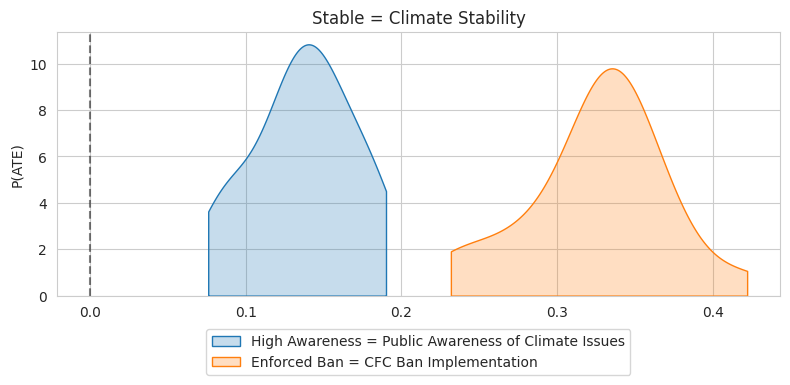

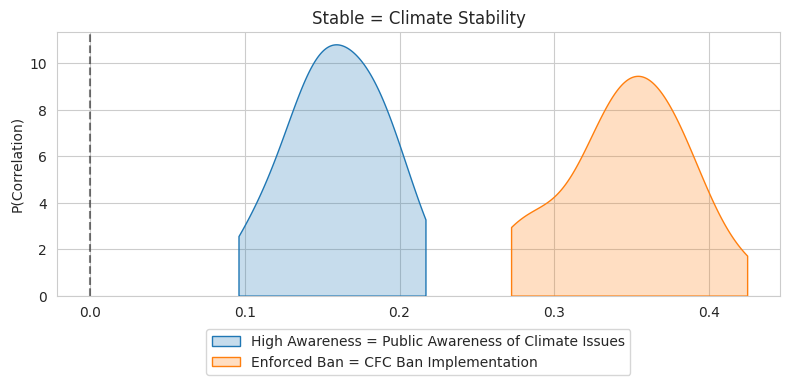

In [270]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [271]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Environmental Policies' (0='Weak Policies', 1='Strong Policies') means The presence and effectiveness of environmental policies, with 0 indicating weak policies and 1 strong policies.
Variable 'Public Awareness of Climate Issues' (0='

In [272]:
# verbalization = ctx['verbs'] # ["without", "in the absence of"]
#################################################
verbalization_raw = '''
{
  "Environmental Policies": {
    "descriptor": ["the state of environmental policies", "the robustness of environmental measures"],
    "subject": "environmental guidelines",
    "predicate0": ["are not stringent", "lack rigor"],
    "predicate1": ["are strong", "are rigorously enforced"],
    "pronoun": "they",
    "nounclause0": ["environmental policies are weak", "there is a lack of strong environmental measures"],
    "nounclause1": ["environmental policies are strong", "there is a strong emphasis on environmental conservation"],
    "preposition": ["under", "amid"],
    "domain": "these regulations",
    "subclause0": ["the guidelines are not strict", "little emphasis is placed on environmental protection"],
    "subclause1": ["the regulations are strictly enforced", "great emphasis is placed on environmental protection"],
    "condition0": ["If the environmental policies are weak", "In cases of lax environmental regulation"],
    "condition1": ["If environmental policies are strongly enforced", "In cases of rigorous environmental measures"],
    "action0": ["if environmental policies are relaxed", "if environmental regulations are loosened"],
    "action1": ["if environmental policies are strengthened", "if stricter environmental measures are implemented"]
  },
  "Public Awareness of Climate Issues": {
    "descriptor": ["the level of public awareness about climate issues", "public consciousness regarding climate change"],
    "subject": "the general public",
    "predicate0": ["is not well-informed about climate issues", "shows little concern for climate change"],
    "predicate1": ["is highly aware of climate issues", "expresses significant concern for climate change"],
    "pronoun": "they",
    "nounclause0": ["public awareness about climate issues is low", "there is minimal concern about climate change among the public"],
    "nounclause1": ["public awareness about climate issues is high", "there is a heightened concern about climate change among the public"],
    "preposition": ["among", "within"],
    "domain": "the population",
    "subclause0": ["there is a lack of knowledge about climate change", "concern for climate issues is minimal"],
    "subclause1": ["there is an increased knowledge about climate change", "concern for climate issues is prominent"],
    "condition0": ["If public awareness about climate issues is low", "When there is little public concern for climate change"],
    "condition1": ["If public awareness about climate issues is high", "When there is significant public concern for climate change"],
    "action0": ["if people become less aware of climate issues", "if public concern for climate change decreases"],
    "action1": ["if people become more aware of climate issues", "if public concern for climate change increases"]
  },
  "CFC Ban Implementation": {
    "descriptor": ["the status of the CFC ban", "the enforcement of the CFC prohibition"],
    "subject": "this policy",
    "predicate0": ["is not implemented", "remains unenforced"],
    "predicate1": ["is fully implemented", "is strictly enforced"],
    "pronoun": "it",
    "nounclause0": ["the CFC ban is not in effect", "there is no enforcement of the CFC ban"],
    "nounclause1": ["the CFC ban is fully in effect", "the CFC ban is being strictly enforced"],
    "preposition": ["despite", "in the absence of"],
    "domain": "this regulation",
    "subclause0": ["the ban is not active", "no measures are taken against CFCs"],
    "subclause1": ["the ban is in full force", "strict measures are taken against CFCs"],
    "condition0": ["If the CFC ban is not enforced", "When there is no implementation of the CFC ban"],
    "condition1": ["If the CFC ban is fully enforced", "When the CFC ban is actively implemented"],
    "action0": ["if the CFC ban remains unenforced", "if no action is taken against CFCs"],
    "action1": ["if the CFC ban is put into action", "if strict measures against CFCs are implemented"]
  },
  "Industrial Growth": {
    "descriptor": ["the rate of industrial growth", "the pace of industrial expansion"],
    "subject": "industrial sectors",
    "predicate0": ["experience slow growth", "are expanding at a slow pace"],
    "predicate1": ["are rapidly growing", "are expanding quickly"],
    "pronoun": "they",
    "nounclause0": ["industrial growth is low", "there is a slow pace of industrial expansion"],
    "nounclause1": ["industrial growth is high", "there is a rapid pace of industrial expansion"],
    "preposition": ["in", "with"],
    "domain": "these economies",
    "subclause0": ["growth in the industry is sluggish", "the expansion rate is minimal"],
    "subclause1": ["there is a boom in the industry", "the expansion rate is significant"],
    "condition0": ["If industrial growth is low", "When the industrial sector expands slowly"],
    "condition1": ["If industrial growth is high", "When the industrial sector expands rapidly"],
    "action0": ["if industrial growth slows down", "if the pace of industrial expansion decreases"],
    "action1": ["if there is a surge in industrial growth", "if the pace of industrial expansion increases"]
  },
  "Ozone Layer Recovery": {
    "descriptor": ["the state of the ozone layer's recovery", "the progress in healing the ozone layer"],
    "subject": "the ozone layer",
    "predicate0": ["is not recovering well", "shows signs of deterioration"],
    "predicate1": ["is recovering effectively", "shows signs of improvement"],
    "pronoun": "it",
    "nounclause0": ["the ozone layer's recovery is poor", "there is ongoing deterioration of the ozone layer"],
    "nounclause1": ["the ozone layer's recovery is progressing well", "there is noticeable improvement in the ozone layer"],
    "preposition": ["despite", "amid"],
    "domain": "these environmental conditions",
    "subclause0": ["recovery efforts are not effective", "there is little progress in healing"],
    "subclause1": ["recovery efforts are yielding results", "significant progress is being made in healing"],
    "condition0": ["If the ozone layer's recovery is poor", "When there is a lack of improvement in the ozone layer"],
    "condition1": ["If the ozone layer's recovery is good", "When there is significant improvement in the ozone layer"],
    "action0": ["if efforts to recover the ozone layer fail", "if there is continued deterioration of the ozone layer"],
    "action1": ["if effective measures for ozone recovery are taken", "if there is a significant improvement in the ozone layer"]
  },
  "Greenhouse Gas Emissions": {
    "descriptor": ["the level of greenhouse gas emissions", "the rate of emissions into the atmosphere"],
    "subject": "these emissions",
    "predicate0": ["are high", "pose a significant environmental threat"],
    "predicate1": ["are low", "are managed effectively"],
    "pronoun": "they",
    "nounclause0": ["greenhouse gas emissions are high", "there is a significant amount of emissions released"],
    "nounclause1": ["greenhouse gas emissions are low", "emission levels are well-controlled"],
    "preposition": ["in", "among"],
    "domain": "these industries",
    "subclause0": ["the emission of greenhouse gases is substantial", "environmental impact is significant"],
    "subclause1": ["emission levels are kept to a minimum", "environmental impact is mitigated"],
    "condition0": ["If greenhouse gas emissions are high", "When there is a significant release of emissions"],
    "condition1": ["If greenhouse gas emissions are low", "When emissions are well-regulated"],
    "action0": ["if greenhouse gas emissions increase", "if there is a rise in emissions"],
    "action1": ["if greenhouse gas emissions decrease", "if effective measures to reduce emissions are taken"]
  },
  "Climate Stability": {
    "descriptor": ["the stability of the global climate", "the balance of climate patterns", "the steadiness of weather systems"],
    "subject": "the climate",
    "predicate0": ["is experiencing changes", "is showing signs of instability"],
    "predicate1": ["remains stable", "is maintaining its regular pattern"],
    "pronoun": "it",
    "nounclause0": ["the climate is going through changes", "weather patterns are unstable"],
    "nounclause1": ["the climate remains stable", "weather patterns are consistent"],
    "preposition": ["in", "across"],
    "domain": "regions",
    "subclause0": ["the climate is changing", "instability in weather is observed"],
    "subclause1": ["there is climate stability", "weather patterns are steady"],
    "condition0": ["when the climate is unstable", "if weather patterns are changing"],
    "condition1": ["when the climate is stable", "if weather patterns remain consistent"],
    "action0": ["if the climate destabilizes", "should the weather systems change"],
    "action1": ["if the climate remains stable", "should weather patterns stay consistent"]
  },
  "Research Investment in Climate Science": {
    "descriptor": ["the funding for climate science research", "the investment in climate studies", "the support for climate research"],
    "subject": "research in climate science",
    "predicate0": ["receives minimal funding", "is underfunded"],
    "predicate1": ["is well-funded", "receives substantial investment"],
    "pronoun": "it",
    "nounclause0": ["climate science research is underfunded", "there is minimal investment in climate studies"],
    "nounclause1": ["climate science research is well-funded", "there is significant investment in climate studies"],
    "preposition": ["in", "among"],
    "domain": ["research initiatives", "climate projects"],
    "subclause0": ["funding for research is low", "investment in studies is minimal"],
    "subclause1": ["funding for research is high", "investment in studies is substantial"],
    "condition0": ["with low investment in research", "if funding for climate science is minimal"],
    "condition1": ["with high investment in research", "if funding for climate science is substantial"],
    "action0": ["if investment in climate research decreases", "should funding for climate studies drop"],
    "action1": ["if investment in climate research increases", "should funding for climate studies rise"]
  }
}
'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)
assert all(node['name'] in ctx['verbs'] for node in nodes), f'{[node["name"] for node in nodes if node["name"] not in ctx["verbs"]]!r}'

In [273]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

This article brings to light how the 1987 global treaty to ban CFCs, chemicals harming the ozone layer, might have helped us avoid severe climate issues today. To explore this further, we could look at historical temperature records, greenhouse gas levels, and ozone layer measurements over the past few decades. By comparing these data before and after the ban, we might see how significantly this action contributed to slowing down climate change.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Public Awareness of Climate Issues') > 0
	2. ATE('CFC Ban Implementation') < 0
	3. ATE('CFC Ban Implementation') < ATE('Public Awareness of Climate Issues')
	4. |ATE('CFC Ban Implementation')| > |ATE('Public Awareness of Climate Issues')|
	5. CATE('Public Aware

In [275]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {
        "question": "Does increasing public awareness of climate issues generally lead to more positive outcomes for climate stability?",
        "answer": "yes",
        "claim": "Increasing public awareness of climate issues generally leads to more positive outcomes for climate stability."
    },
    "2": {
        "question": "Does implementing a CFC ban typically worsen climate stability?",
        "answer": "no",
        "claim": "Implementing a CFC ban does not typically worsen climate stability."
    },
    "3": {
        "question": "Is the impact of implementing a CFC ban on climate stability less positive than the impact of increasing public awareness of climate issues?",
        "answer": "yes",
        "claim": "The positive impact on climate stability is less from implementing a CFC ban compared to increasing public awareness of climate issues."
    },
    "4": {
        "question": "Is the absolute impact of implementing a CFC ban on climate stability greater than that of increasing public awareness of climate issues?",
        "answer": "no",
        "claim": "The absolute impact on climate stability from implementing a CFC ban is not greater than that from increasing public awareness of climate issues."
    },
    "5": {
        "question": "In the context of weak environmental policies, does increasing public awareness of climate issues tend to lead to worse outcomes for climate stability?",
        "answer": "no",
        "claim": "Even under weak environmental policies, increasing public awareness of climate issues does not lead to worse outcomes for climate stability."
    },
    "6": {
        "question": "When environmental policies are weak, does implementing a CFC ban typically improve climate stability?",
        "answer": "yes",
        "claim": "Implementing a CFC ban tends to improve climate stability, especially when environmental policies are weak."
    },
    "7": {
        "question": "Under weak environmental policies, is the positive impact on climate stability greater from increasing public awareness of climate issues than from implementing a CFC ban?",
        "answer": "yes",
        "claim": "Under weak environmental policies, the positive impact on climate stability is greater from increasing public awareness than from implementing a CFC ban."
    },
    "8": {
        "question": "Is the absolute impact on climate stability smaller from implementing a CFC ban than from increasing public awareness of climate issues under weak environmental policies?",
        "answer": "yes",
        "claim": "Under weak environmental policies, the absolute impact on climate stability is smaller from implementing a CFC ban compared to increasing public awareness."
    },
    "9": {
        "question": "In the presence of strong environmental policies, does increasing public awareness of climate issues generally lead to better climate stability?",
        "answer": "yes",
        "claim": "Increasing public awareness of climate issues leads to better climate stability, particularly when environmental policies are strong."
    },
    "10": {
        "question": "When environmental policies are strong, does implementing a CFC ban typically worsen climate stability?",
        "answer": "no",
        "claim": "Implementing a CFC ban does not worsen climate stability, even when environmental policies are strong."
    },
    "11": {
        "question": "With strong environmental policies, is the positive impact on climate stability greater from increasing public awareness of climate issues than from implementing a CFC ban?",
        "answer": "yes",
        "claim": "With strong environmental policies, the positive impact on climate stability is greater from increasing public awareness than from implementing a CFC ban."
    },
    "12": {
        "question": "Is the absolute impact on climate stability greater from implementing a CFC ban than from increasing public awareness of climate issues under strong environmental policies?",
        "answer": "no",
        "claim": "Under strong environmental policies, the absolute impact on climate stability is not greater from implementing a CFC ban compared to increasing public awareness."
    },
    "13": {
        "question": "Does increasing public awareness of climate issues have a greater positive impact on climate stability under strong environmental policies than under weak ones?",
        "answer": "yes",
        "claim": "Increasing public awareness of climate issues has a greater positive impact on climate stability under strong environmental policies than under weak ones."
    },
    "14": {
        "question": "Is the absolute impact on climate stability from increasing public awareness of climate issues greater under strong environmental policies than under weak ones?",
        "answer": "yes",
        "claim": "The absolute impact on climate stability from increasing public awareness is greater under strong environmental policies than under weak ones."
    },
    "15": {
        "question": "Does implementing a CFC ban have a lesser positive impact on climate stability under strong environmental policies compared to weak ones?",
        "answer": "yes",
        "claim": "Implementing a CFC ban has a lesser positive impact on climate stability under strong environmental policies compared to weak ones."
    },
    "16": {
        "question": "Is the absolute impact on climate stability from implementing a CFC ban smaller under strong environmental policies than under weak ones?",
        "answer": "yes",
        "claim": "The absolute impact on climate stability from implementing a CFC ban is smaller under strong environmental policies than under weak ones."
    },
    "17": {
        "question": "In the context of low industrial growth, does increasing public awareness of climate issues generally lead to better climate stability?",
        "answer": "yes",
        "claim": "Increasing public awareness of climate issues leads to better climate stability, especially in the context of low industrial growth."
    },
    "18": {
        "question": "When industrial growth is low, does implementing a CFC ban typically improve climate stability?",
        "answer": "yes",
        "claim": "Implementing a CFC ban tends to improve climate stability, particularly when industrial growth is low."
    },
    "19": {
        "question": "Under low industrial growth, is the positive impact on climate stability greater from implementing a CFC ban than from increasing public awareness of climate issues?",
        "answer": "yes",
        "claim": "Under low industrial growth, the positive impact on climate stability is greater from implementing a CFC ban than from increasing public awareness."
    },
    "20": {
        "question": "Is the absolute impact on climate stability smaller from increasing public awareness of climate issues than from implementing a CFC ban under low industrial growth?",
        "answer": "yes",
        "claim": "Under low industrial growth, the absolute impact on climate stability is smaller from increasing public awareness compared to implementing a CFC ban."
    },
    "21": {
        "question": "In the context of high industrial growth, does increasing public awareness of climate issues tend to lead to worse outcomes for climate stability?",
        "answer": "no",
        "claim": "Even under high industrial growth, increasing public awareness of climate issues does not lead to worse outcomes for climate stability."
    },
    "22": {
        "question": "When industrial growth is high, does implementing a CFC ban typically improve climate stability?",
        "answer": "yes",
        "claim": "Implementing a CFC ban tends to improve climate stability, especially when industrial growth is high."
    },
    "23": {
        "question": "Under high industrial growth, is the positive impact on climate stability greater from implementing a CFC ban than from increasing public awareness of climate issues?",
        "answer": "yes",
        "claim": "Under high industrial growth, the positive impact on climate stability is greater from implementing a CFC ban than from increasing public awareness."
    },
    "24": {
        "question": "Is the absolute impact on climate stability greater from implementing a CFC ban than from increasing public awareness of climate issues under high industrial growth?",
        "answer": "yes",
        "claim": "Under high industrial growth, the absolute impact on climate stability is greater from implementing a CFC ban compared to increasing public awareness."
    },
    "25": {
        "question": "Does increasing public awareness of climate issues have a greater positive impact on climate stability under high industrial growth than under low growth?",
        "answer": "yes",
        "claim": "Increasing public awareness of climate issues has a greater positive impact on climate stability under high industrial growth than under low growth."
    },
    "26": {
        "question": "Is the absolute impact on climate stability from increasing public awareness of climate issues greater under high industrial growth than under low growth?",
        "answer": "yes",
        "claim": "The absolute impact on climate stability from increasing public awareness is greater under high industrial growth than under low growth."
    },
    "27": {
        "question": "Does implementing a CFC ban have a lesser positive impact on climate stability under low industrial growth compared to high growth?",
        "answer": "no",
        "claim": "Implementing a CFC ban does not have a lesser positive impact on climate stability under low industrial growth compared to high growth."
    },
    "28": {
        "question": "Is the absolute impact on climate stability from implementing a CFC ban smaller under low industrial growth than under high growth?",
        "answer": "no",
        "claim": "The absolute impact on climate stability from implementing a CFC ban is not smaller under low industrial growth than under high growth."
}}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [276]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Ozone_Recovery_and_Climate_Change_Impact.json'